## 1. 소프트맥스 회귀의 비용 함수 구현

In [9]:
import torch
import torch.nn.functional as F
torch.manual_seed(1)

z = torch.FloatTensor([1, 2, 3])
hypothesis = F.softmax(z, dim=0)
print(hypothesis)

hypothesis.sum()
z = torch.rand(3, 5, requires_grad=True)
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

y = torch.randint(5, (3,)).long()
print(y)

# 모든 원소가 0의 값을 가진 3 × 5 텐서 생성
y_one_hot = torch.zeros_like(hypothesis) 
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

print(y.unsqueeze(1))

print(y_one_hot)

cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)



tensor([0.0900, 0.2447, 0.6652])
tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)
tensor([0, 2, 1])
tensor([[0],
        [2],
        [1]])
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])
tensor(1.4689, grad_fn=<MeanBackward0>)


In [11]:
# Low level
torch.log(F.softmax(z, dim=1))

# High level
F.log_softmax(z, dim=1)



tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

In [14]:
# Low level
# 첫번째 수식
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()
# 두번째 수식
(y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean()

# High level
# 세번째 수식
F.nll_loss(F.log_softmax(z, dim=1), y)
# 여기서 nll이란 Negative Log Likelihood의 약자입니다. 

# 네번째 수식
F.cross_entropy(z, y)
## 중요: F.cross_entropy는 비용 함수에 소프트맥스 함수까지 포함하고 있음을 기억하고 있어야 구현 시 혼동하지 않습니다.




tensor(1.4689, grad_fn=<NllLossBackward0>)

## 소프트맥스 회귀 구현하기

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)


In [17]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)


In [18]:
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape)


torch.Size([8, 3])


In [19]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)


In [20]:
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # 가설
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1) 
    

    # 비용 함수
    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704200
Epoch  200/1000 Cost: 0.622999
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515291
Epoch  500/1000 Cost: 0.467662
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375402
Epoch  800/1000 Cost: 0.329766
Epoch  900/1000 Cost: 0.285073
Epoch 1000/1000 Cost: 0.248155


In [21]:
# 소프트 맥스 회귀 구현하기 (하이-레벨)
#  F.cross_entropy()를 사용하여 비용 함수를 구현
# F.cross_entropy()는 그 자체로 소프트 맥스 함수를 포함하고 있음

# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704200
Epoch  200/1000 Cost: 0.622999
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515292
Epoch  500/1000 Cost: 0.467662
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375401
Epoch  800/1000 Cost: 0.329765
Epoch  900/1000 Cost: 0.285073
Epoch 1000/1000 Cost: 0.248155


In [22]:
# 소프트맥스 회귀 nn.Module로 구현하기

# 모델을 선언 및 초기화. 4개의 특성을 가지고 3개의 클래스로 분류. input_dim=4, output_dim=3.
model = nn.Linear(4, 3)

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))



Epoch    0/1000 Cost: 1.616785
Epoch  100/1000 Cost: 0.658891
Epoch  200/1000 Cost: 0.573443
Epoch  300/1000 Cost: 0.518151
Epoch  400/1000 Cost: 0.473265
Epoch  500/1000 Cost: 0.433516
Epoch  600/1000 Cost: 0.396563
Epoch  700/1000 Cost: 0.360914
Epoch  800/1000 Cost: 0.325392
Epoch  900/1000 Cost: 0.289178
Epoch 1000/1000 Cost: 0.254148


In [24]:
# 소프트맥스 회귀 클래스로 구현하기

class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # Output이 3!

    def forward(self, x):
        return self.linear(x)

model = SoftmaxClassifierModel()

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))




Epoch    0/1000 Cost: 2.637636
Epoch  100/1000 Cost: 0.647903
Epoch  200/1000 Cost: 0.564643
Epoch  300/1000 Cost: 0.511043
Epoch  400/1000 Cost: 0.467249
Epoch  500/1000 Cost: 0.428281
Epoch  600/1000 Cost: 0.391924
Epoch  700/1000 Cost: 0.356742
Epoch  800/1000 Cost: 0.321577
Epoch  900/1000 Cost: 0.285617
Epoch 1000/1000 Cost: 0.250818


## 소프트맥스 회귀로 MNIST 데이터 분류하기

In [25]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random


In [26]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)


다음 기기로 학습합니다: cpu


In [27]:
import torch
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}") 

MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? True


In [28]:
device = torch.device("mps")

In [29]:
print(f"현재 사용 중인 장치: {device}")

현재 사용 중인 장치: mps


In [31]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'mps':
    torch.mps.manual_seed_all(777)


In [32]:
# hyperparameters
training_epochs = 15
batch_size = 100


In [33]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:09<00:00, 1050748.72it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 123047.61it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1052451.18it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 221809.22it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [34]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)


In [35]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)


In [36]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)


In [37]:
# 학습하기
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')


Epoch: 0001 cost = 0.535150588
Epoch: 0002 cost = 0.359577715
Epoch: 0003 cost = 0.331264228
Epoch: 0004 cost = 0.316404700
Epoch: 0005 cost = 0.307107002
Epoch: 0006 cost = 0.300456524
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956169
Epoch: 0009 cost = 0.287074089
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526889
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874764
Epoch: 0015 cost = 0.274422765
Learning finished


Accuracy: 0.8883000016212463
Label:  5
Prediction:  5


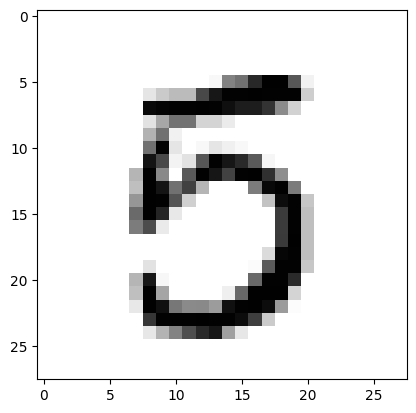

In [43]:
#평가하기
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()
